In [57]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [58]:
DIR = "/Users/maggicl/Git/bachelorThesis/figure_7/"

In [69]:
def tier(p):
    if p <= 99:
        return "Free"
    elif p <= 115:
        return "Best effort batch"
    elif p <= 119:
        return "Mid"
    elif p <= 359:
        return "Production"
    else:
        return "Monitoring"

def categorical_plot(df, key, title, sorted_xs = None):
    
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7]:
            xs = xs.union(np.array(df[df["term"] == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7]:
        ys = []
        if xs[0] == "-1":
            del xs[0]
        for x in xs:
            partsum = df[(df["term"] != -1) & (df[key] == x)]["count"].sum().astype(int)
            y = df[(df["term"] == t) & (df[key] == x)]["count"]
            ys.append(100 * ((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any()
                             else 0))
        lines.append(ax.plot(xs,ys, marker='.')[0])

    plt.xticks(xs)
    plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL", "LOST"],
              bbox_to_anchor=(1,1))
    plt.title(title)
    plt.savefig('../report/figures/figure_7/%s-%s.pgf' % 
                (key, cluster))
    plt.show()

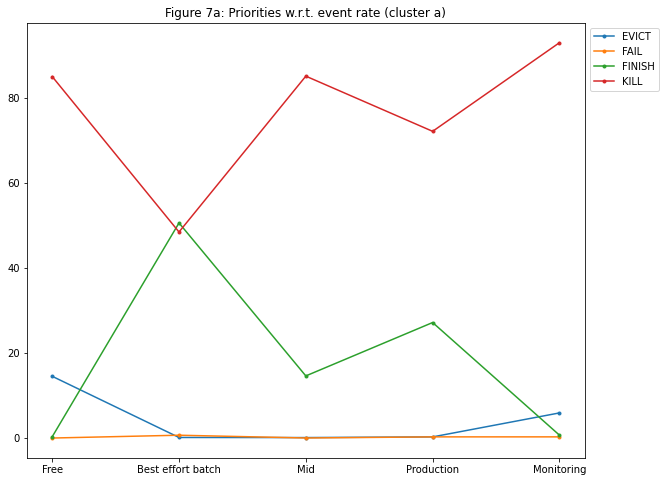

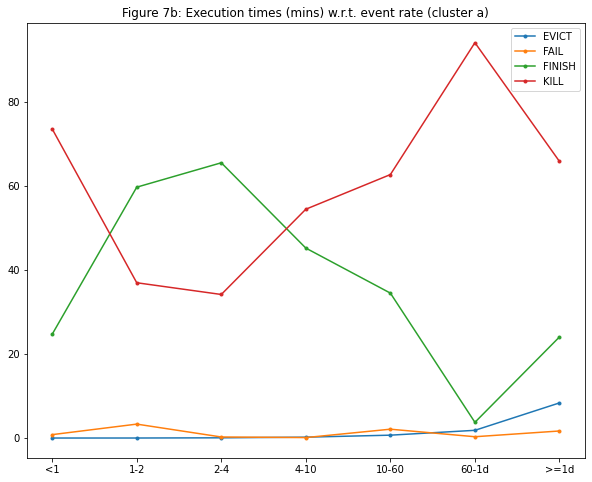

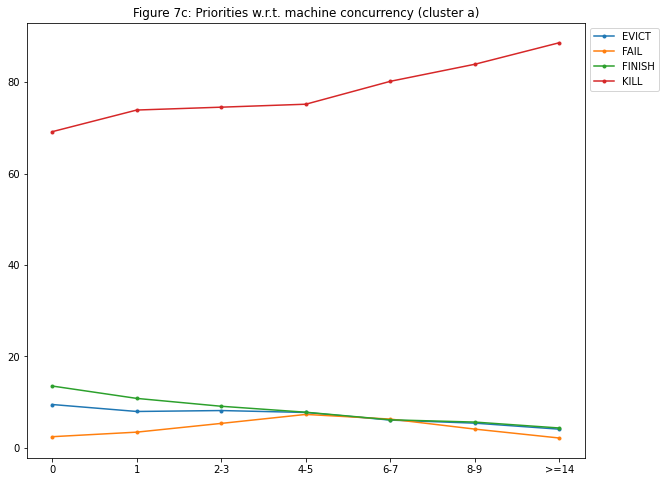

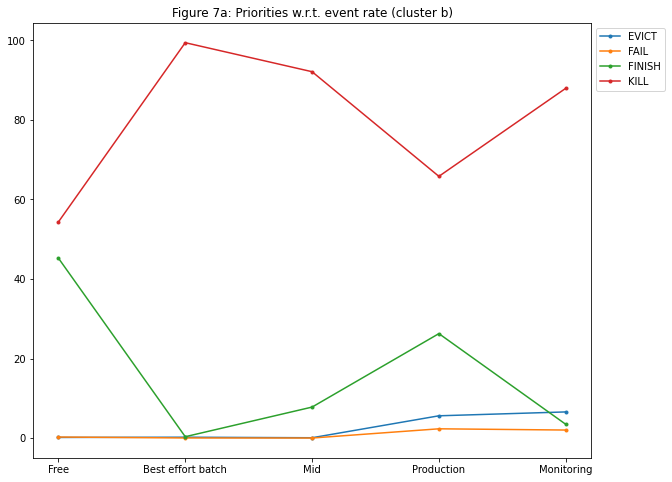

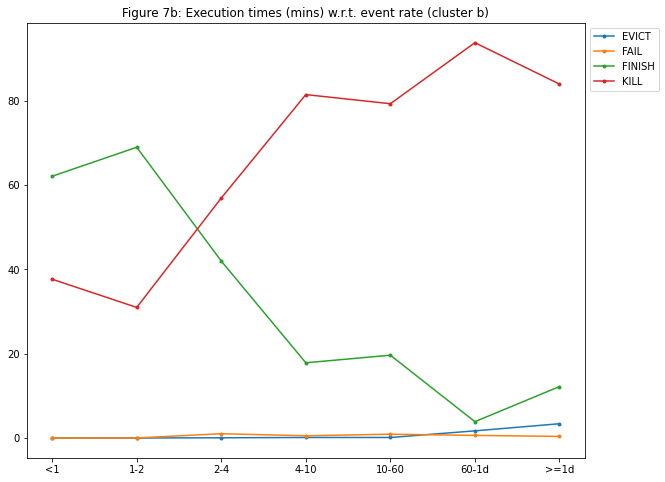

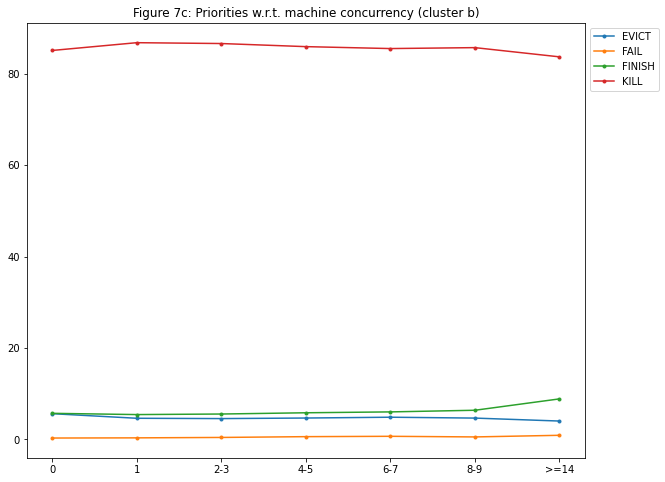

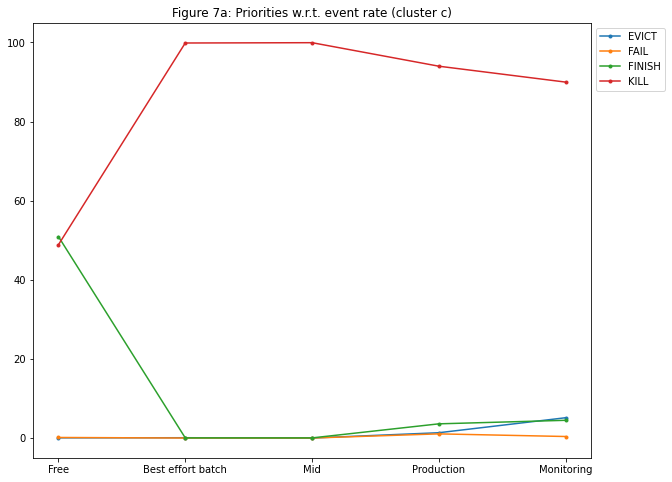

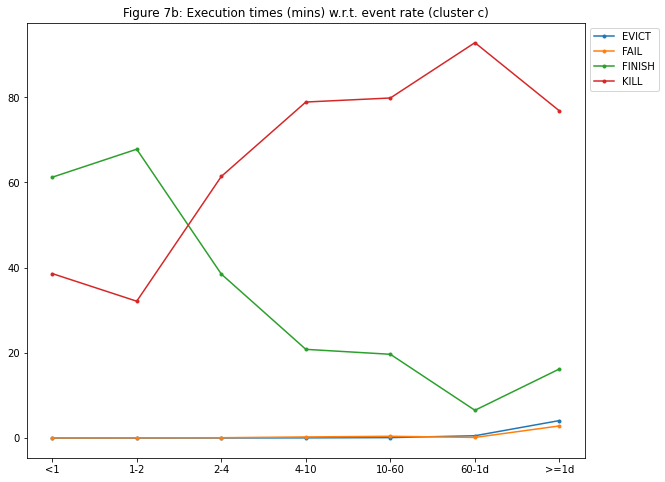

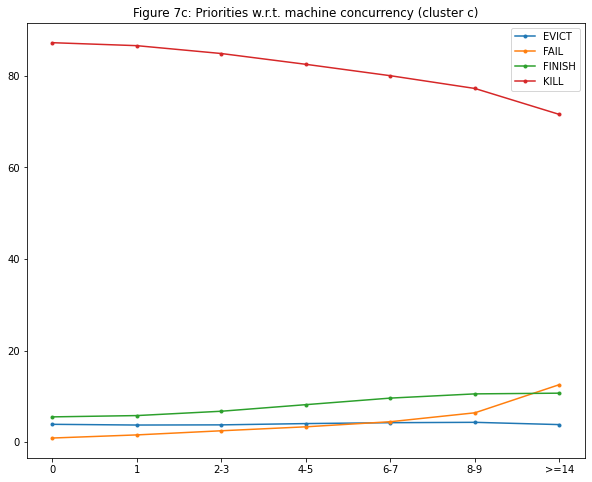

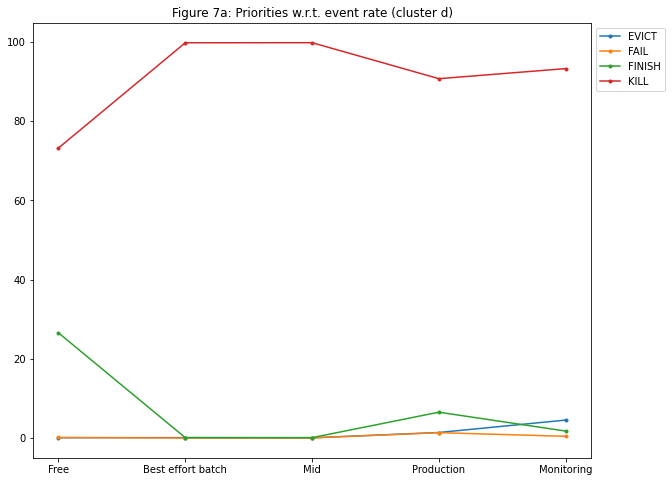

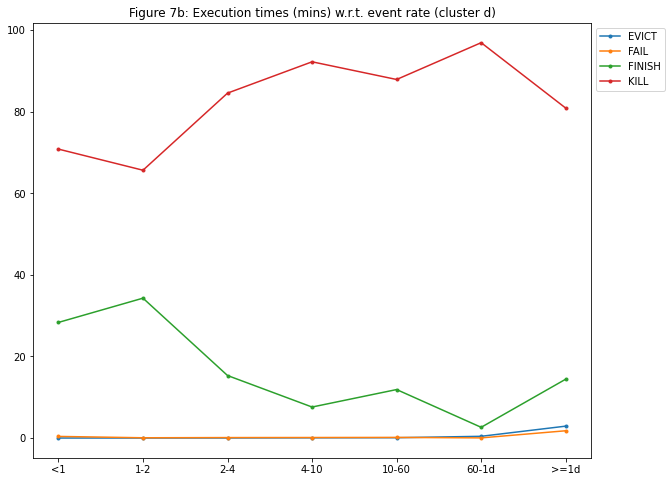

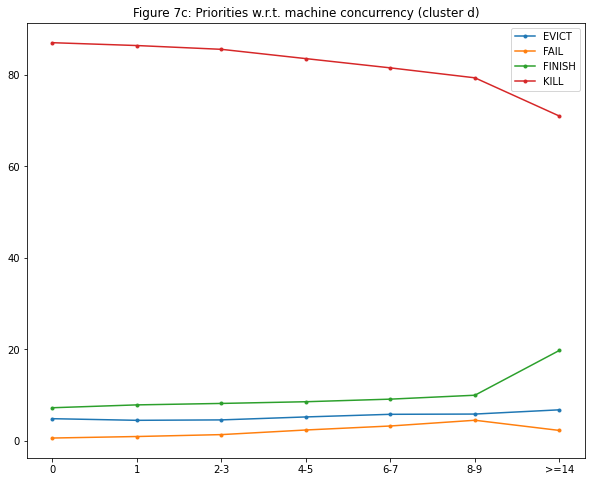

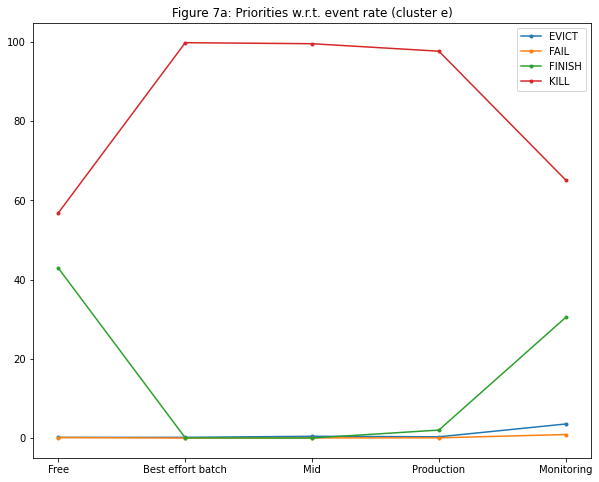

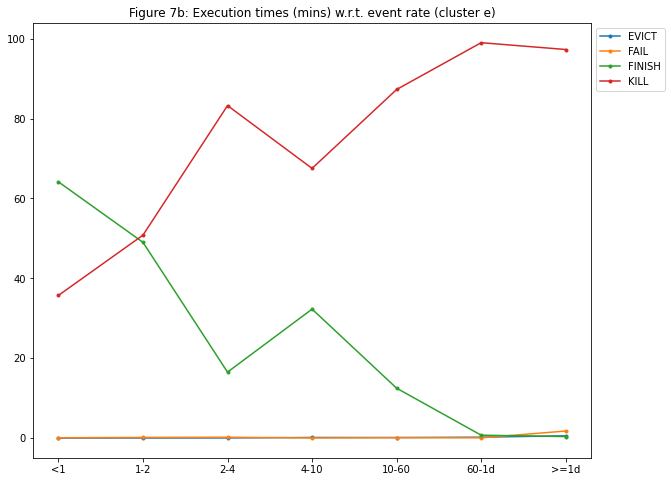

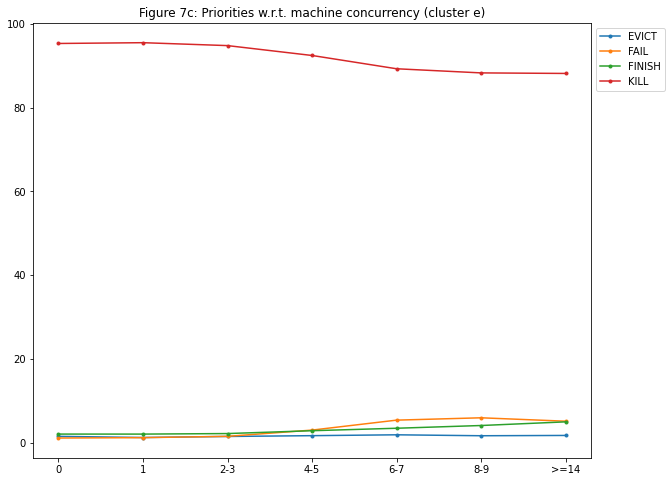

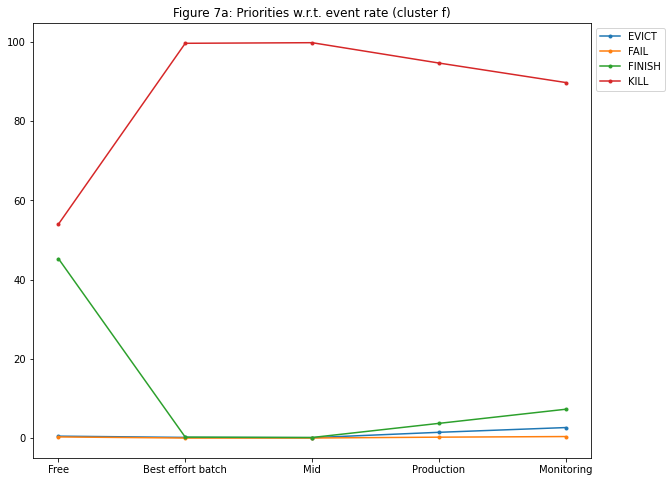

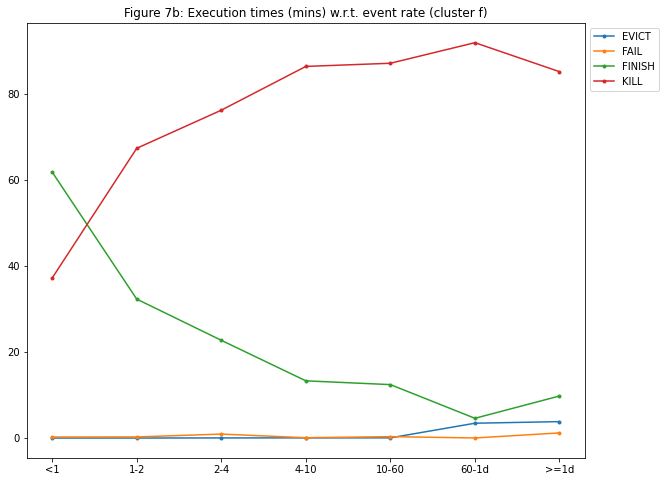

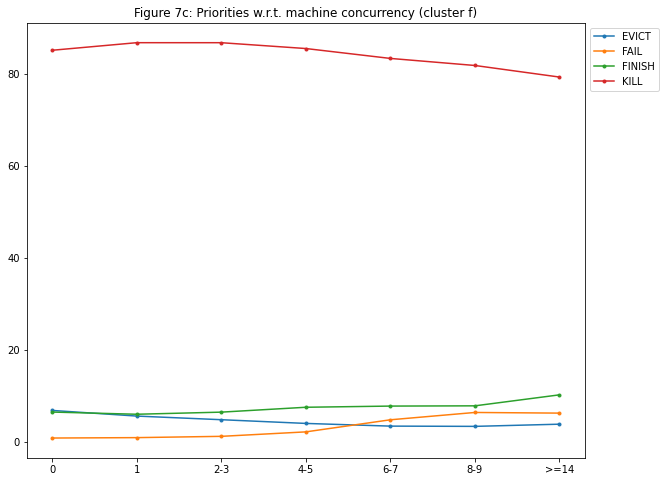

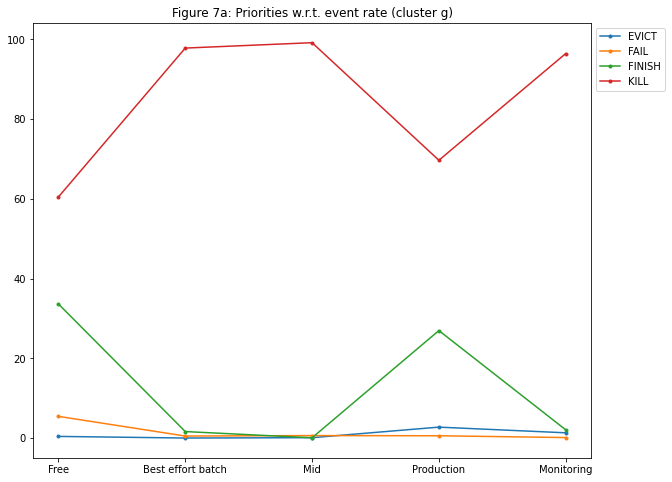

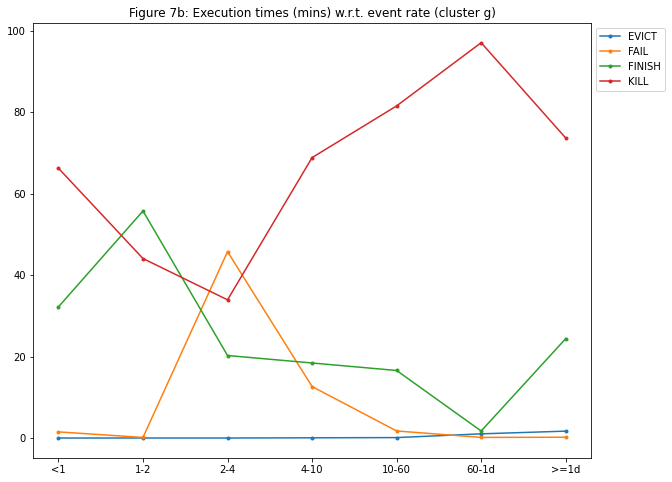

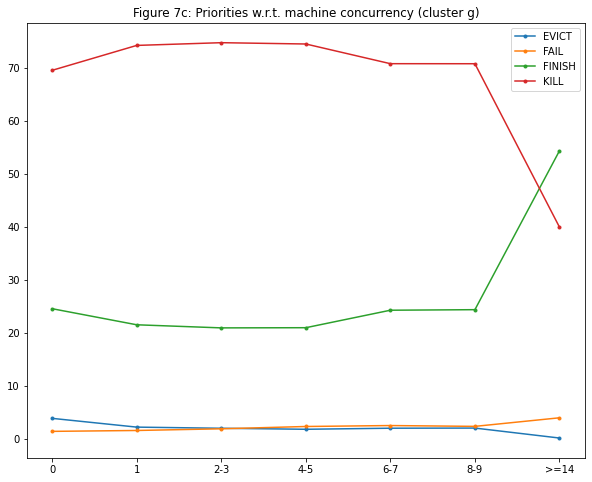

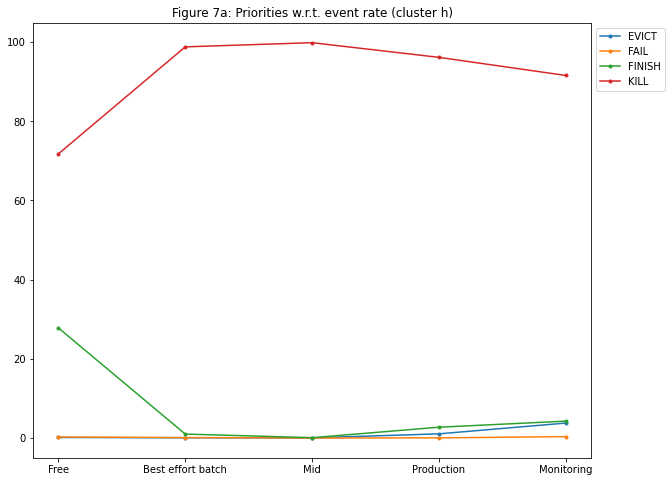

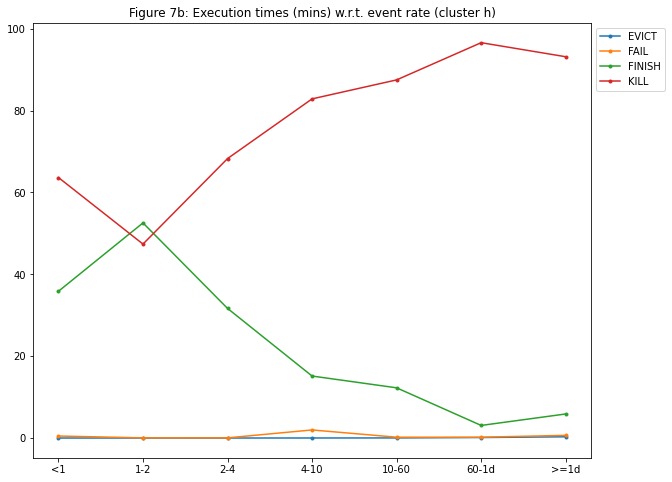

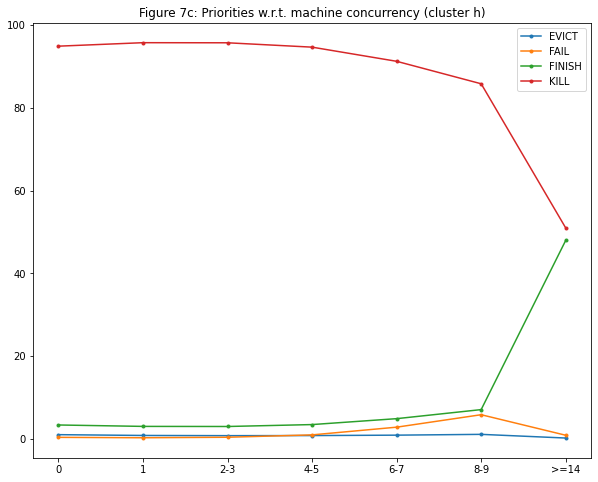

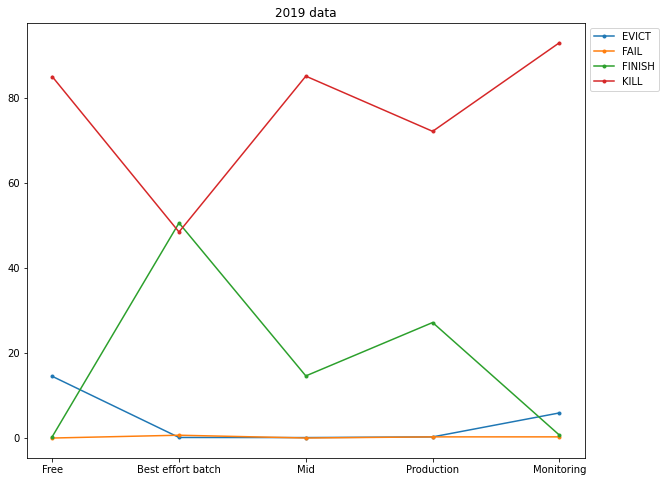

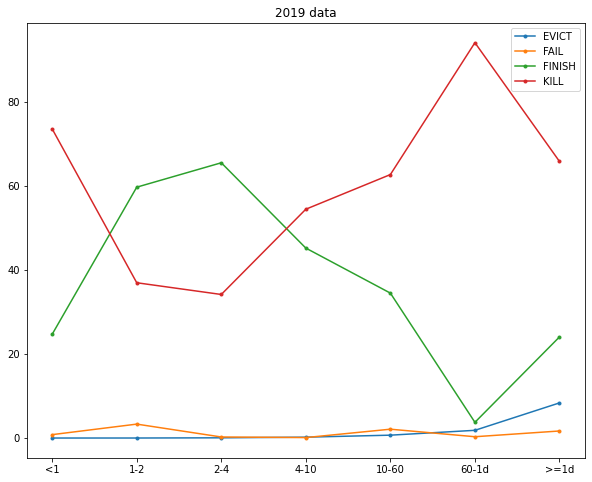

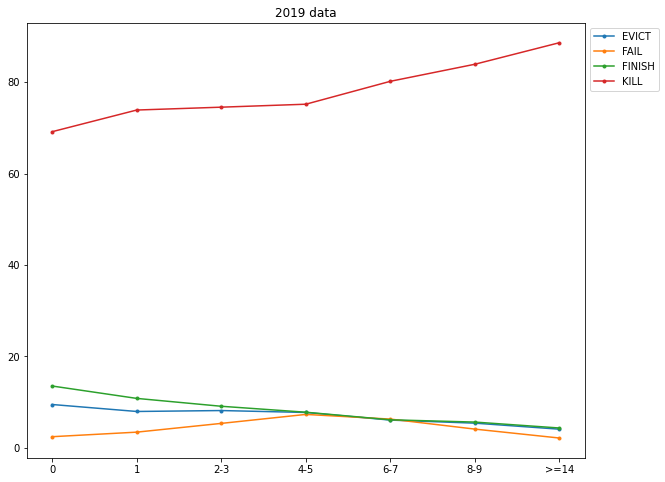

In [70]:
dfatot = None
dfbtot = None
dfctot = None

for cluster in "abcdefgh":
    # Processing figure 7a
    
    dfa = pd.read_csv(glob.glob(DIR + cluster + "_priority/part-*")[0], header=None,
                    names=["term", "priority", "count"])
    dfa["tier"] = dfa["priority"].apply(tier)
    dfa = dfa[dfa["priority"].ge(0)]
    dfa = dfa.groupby(["tier", "term"]).sum().reset_index()
    dfa = dfa[dfa["term"].isin(range(4,8))]
    del dfa["priority"]
    if dfatot is None:
        dfatot = dfa
    else:
        dfatot.append(dfa)
    
    xs = ["Free", "Best effort batch", "Mid", "Production", "Monitoring"]
    categorical_plot(dfa, "tier", "Figure 7a: Priorities w.r.t. event rate (cluster " + cluster + ")", xs)
    
    # Processing figure 7b
    
    dfb = pd.read_csv(glob.glob(DIR + cluster + "_exectime/part-*")[0], header=None,
                names=["term", "ignore", "exectime", "count"])
    del dfb["ignore"]
    dfb = dfb.sort_values(["term", "exectime"])
    if dfbtot is None:
        dfbtot = dfb
    else:
        dfbtot.append(dfb)
    
    xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
    categorical_plot(dfb, "exectime", "Figure 7b: Execution times (mins) w.r.t. event rate (cluster " + cluster + ")", xs)

    # Processing figure 7c
    
    bins = ["0", "1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"]
    bin_max = [1, 3, 5, 7, 9, 11, 13]
    def map_bins(value):
        for i, m in enumerate(bin_max):
            if value < m:
                return bins[i-1]
        return bins[-1]
    
    dfc = pd.read_csv(DIR + cluster + "_figure7c.csv", header=0)
    dfc = dfc.sort_values(["term", "n_exec"])
    dfc["n_exec"] = dfc["n_exec"].map(map_bins)
    dfc = dfc.groupby(["term", "n_exec"]).sum().reset_index()
    categorical_plot(dfc, "n_exec", "Figure 7c: Priorities w.r.t. machine concurrency (cluster " + cluster + ")")
    if dfctot is None:
        dfctot = dfc
    else:
        dfctot.append(dfc)

cluster = "all"
        
dfatot = dfatot.groupby(["tier", "term"]).sum().reset_index()
dfbtot = dfbtot.groupby(["term", "exectime"]).sum().reset_index()
dfctot = dfctot.groupby(["term", "n_exec"]).sum().reset_index()

xs = ["Free", "Best effort batch", "Mid", "Production", "Monitoring"]
categorical_plot(dfatot, "tier", "2019 data", xs)

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfbtot, "exectime", "2019 data", xs)

categorical_plot(dfctot, "n_exec", "2019 data")

